## Introduction ##

In this file we will try out open-source libraries for deep learning and CNN.


### Data

Let's first prepare the data from CIFAR10 dataset.

Source: http://www.cs.utoronto.ca/~kriz/cifar.html

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. 

(we will be using batch_1 only out of 6 batches -- so 10,000 images in total)

The classes are ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

| no. of Classes    | 10            |
|-------------------|---------------|
| Samples per class | ~1,000        |
| Samples total     | 10,000        |
| Dimensionality    | 32x32x3 = 3,072|
| Features          | int 0-255 each pixel     |

In [5]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [6]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
def array_to_image(arr):
    im = arr.reshape((32,32,3),order='F')/255.0
    im = np.transpose(im,axes=(1,0,2))
    return im

In [7]:
# source: http://www.cs.utoronto.ca/~kriz/cifar.html
# get the training data, batch 1 out of 6. do unzip the tar.gz first
from time import strftime
import os

if os.name == 'nt': # Windows
    path = 'cifar\\data_batch_1'
else:
    path = 'cifar/data_batch_1'
    
cifar = unpickle('cifar/data_batch_1')

array_size = 3072
[0 0 0 ..., 0 0 0]
file_name = car_s_000529.png


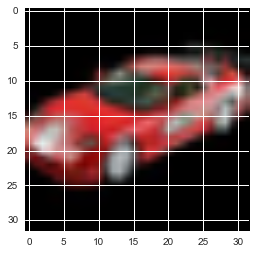

In [8]:
# image data is uint8 array format 
# 3 RGB channels and 32x32 pixels means 32x32x3 = 1024x3 = 3072 numbers in one array
# 10,000 arrays in dataset
lucky_num = randint(0,10000)
sample_arr = cifar["data"][lucky_num].copy()
print 'array_size = {}'.format(len(sample_arr))
print sample_arr
print 'file_name = {}'.format(cifar["filenames"][lucky_num])
#show image
plt.rcParams['figure.figsize'] = (4, 4)
plt.imshow(array_to_image(sample_arr))
plt.show()

In [57]:
# X Format is [image_index, RGB, Height, Width]
X = cifar["data"].copy()
X = X.reshape((-1,3,32,32),order='C')/255.0 - 0.5 #standardize

#set size of input, features, hidden, target
instance_size = X.shape[0]
feature_size = X.shape[1]*X.shape[2]*X.shape[3]
target_size = 10
kernel_size = (12,3,3,3)
weight_size = (10,12,16,16) #softmax layer

#make a flat 10 output with all zeros
Y = np.zeros((instance_size,10))
for j in range(0,instance_size):
    Y[j][cifar['labels'][j]] = 1

#split train and test dataset
train_split = 0.8 #6000.0/instance_size
train_size = 200 #int(train_split*instance_size)
test_size = 40 #instance_size - train_size
index = np.random.permutation(instance_size)
train_ix, test_ix = index[:train_size], index[train_size:train_size+test_size]
Y_train , Y_test = Y[train_ix,:], Y[test_ix,:]
X_train , X_test = X[train_ix,:,:,:], X[test_ix,:,:,:]

### Libraries available in python ###
+ Theano - the granddaddy. Have a few libraries built on top
    + Keras
    + Lasange
+ Tensorflow - the new hotshot from google 
    + Keras (can be used on top)
+ Caffe

### Keras

Sits on top of either [Theano or Tensorflow](https://keras.io/backend/).

Sacrifice performance for ease-of-use.

Be very careful to have compatible .keras config for *image_dim_ordering* and *backend*. Else you will get an unclear error message "Flatten() - input_shape not fully defined"

{
    "image_dim_ordering": "th", 
    "epsilon": 1e-07,
    "floatx": "float32",
    "backend": "theano"
}

In [10]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"

import theano
import keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()
# input: 32x32 images with 3 channels -> (3, 32, 32) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(nb_filter=12, nb_row=3, nb_col=3, border_mode='valid', \
                        batch_input_shape=(None, 3, 32, 32), bias=True))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(output_dim=10, bias=True))
model.add(Activation('softmax'))


sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.fit(X_train, Y_train, batch_size=min(100,int(0.2*train_size)), nb_epoch=10)

Epoch 1/10


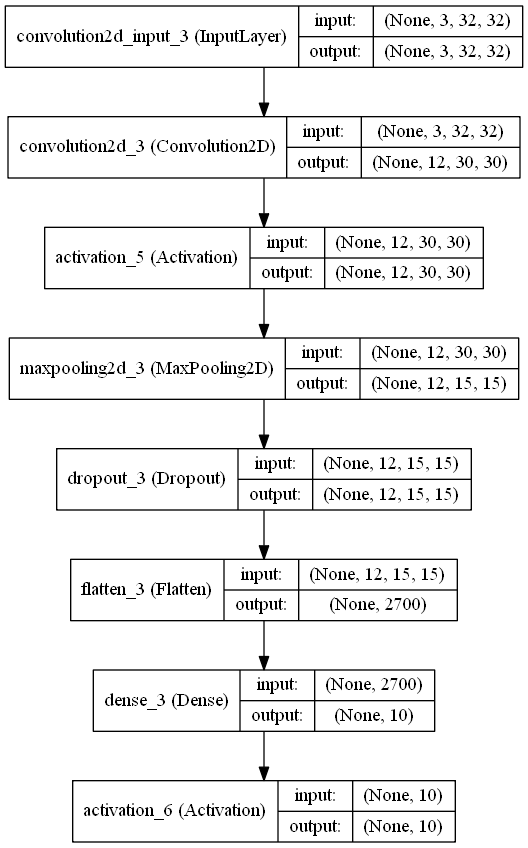

In [55]:
import pydot
from keras.utils.visualize_util import plot as kr_plot
from IPython.display import Image

kr_plot(model, to_file='model.png',show_shapes=True)
Image('model.png',width=380,height=700)

### Theano

#### Installation Note 
If g++ is not installed, theano will use the python implementation instead of optimized C++. 

On windows, in order to avoid all the weird errors, do try to install from the [bleeding edge (dev) version](http://deeplearning.net/software/theano/install.html#bleeding-edge-install-instructions).


In [2]:
# Note: 
# if g++ is not installed, theano will use the python implementation instead of optimized C++. 
# on windows, do try 
import theano
import theano.tensor as T

In [9]:
#Theano hello world - adding 2 matrices
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = theano.function([x, y], z)
print f([[0,1],[2,3]],[[0.5,2.5],[-1.5,-2.7]])

#Theano hello world - compute any symboling expression with multiple outputs
a, b = T.dmatrices('a', 'b')
diff = a - b
abs_diff = abs(diff)
diff_squared = diff**2
f = theano.function([a, b], [diff, abs_diff, diff_squared])
print f([[1,2],[3,4]],[[5,6],[7,8]])

[[ 0.5  3.5]
 [ 0.5  0.3]]
[array([[-4., -4.],
       [-4., -4.]]), array([[ 4.,  4.],
       [ 4.,  4.]]), array([[ 16.,  16.],
       [ 16.,  16.]])]


### Tensorflow

The codes are mostly from the [following tutorial](https://www.tensorflow.org/versions/r0.10/tutorials/deep_cnn/index.html). Note: as of 2016-09-28, Tensorflow works on OSX and Linux only. Still waiting for Windows version...

In [1]:
import tensorflow as tf

ImportError: No module named tensorflow